# 아래와 같은 환경에서 진행하였습니다.
- Python 3.7.9
- tensorflow gpu 2.2.0 (conda create -n tf2 python==3.7 / conda activate tf2 / conda install tensorflow-gpu)
- jupyter (pip install jupyter)
- cuda 10.1 (server 에 pre-installed)
- cudnn 7.6.5 ( server에 pre-installed)

### 본 과정은 아래와 같은 순서로 진행된다.
 - 먼저 Source Hirachy 는 아래와 같이 구성할 예정이다.
  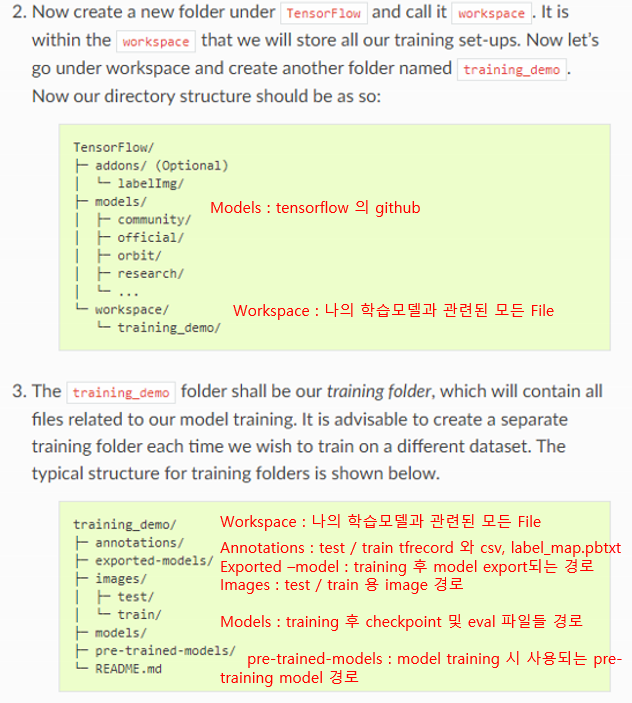
1) object detection 을 위한 tensorflow github download 및 사전 Build test  
2) Dataset 준비   
 - LabelImg 를 통한 image labelling   
 - label 한 image로 tfrecord 만들기  
 - label.pbtxt 생성해두기  
3) Training / Evaluation(eval through Tensorboard)  
4) export model (normal model / tfmodel for each)  
5) 각 모델로 추론해보기 (normal model / tf model test)  
6) tf model 경량화 (진행 중. 내용 확인 필요함)  
 - quantization  
 - prunning   
 - clustering   

# dataset download (이건 test용 dataset으로 별도의 dataset이 있다면 본 구간 Skip

In [1]:
# suspect that we are not ready for well cooked dataset, so skip this
# to download racoon dataset
# !git clone https://github.com/datitran/raccoon_dataset.git

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 652, done.
^Cceiving objects:  65% (424/652), 24.07 MiB | 6.71 MiB/s   


# 1) object detection 을 위한 tensorflow github download 및 사전 Build test

In [ ]:
# Download Tensorflow Object Detection API
!git clone https://github.com/tensorflow/models.git

In [ ]:
# Setup APIS
%cd models/research/
!protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install . --use-feature=2020-resolver
%cd ../../
!pwd

In [5]:
# test for enviroment is clear, should say ok at the bottom for all test 
!python /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/models/research/object_detection/model_lib_tf2_test.py

2020-09-16 07:12:00.582505: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Running tests under Python 3.7.9: /home/yousungchoi/anaconda3/envs/tf2/bin/python
[ RUN      ] CheckpointV2Test.test_restore_map_incompatible_error
2020-09-16 07:12:01.574610: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-09-16 07:12:01.619141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-16 07:12:01.619618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2020-09-16 07:12:01.619662: I tensorflow/stream_executor/cu

2020-09-16 07:12:03.936628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1257] Device interconnect StreamExecutor with strength 1 edge matrix:
2020-09-16 07:12:03.936661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1263]      0 1 2 
2020-09-16 07:12:03.936667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1276] 0:   N N N 
2020-09-16 07:12:03.936670: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1276] 1:   N N N 
2020-09-16 07:12:03.936673: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1276] 2:   N N N 
2020-09-16 07:12:03.936903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-16 07:12:03.937378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-16 07:12:03.937

INFO:tensorflow:time(__main__.CheckpointV2Test.test_restore_map_incompatible_error): 13.32s
I0916 07:12:14.846101 140668945688384 test_util.py:1973] time(__main__.CheckpointV2Test.test_restore_map_incompatible_error): 13.32s
[       OK ] CheckpointV2Test.test_restore_map_incompatible_error
[ RUN      ] CheckpointV2Test.test_restore_v2
INFO:tensorflow:Maybe overwriting train_input_path: /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/models/research/object_detection/test_data/pets_examples.record
I0916 07:12:14.854469 140668945688384 config_util.py:552] Maybe overwriting train_input_path: /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/models/research/object_detection/test_data/pets_examples.record
INFO:tensorflow:Maybe overwriting eval_input_path: /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/models/research/object_detection/test_data/pets_examples.record
I0916 07:12:14.854651 140668945688384 config_util.py:552] May

W0916 07:13:29.128521 140668945688384 dataset_builder.py:83] num_readers has been reduced to 1 to match input file shards.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0916 07:13:32.084429 140668945688384 convolutional_keras_box_predictor.py:154] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0916 07:13:32.084657 140668945688384 convolutional_keras_box_predictor.py:154] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0916 07:13:32.084799 140668945688384 convolutional_keras_box_predictor.py:154] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0916 07:13:32.084929 140668945688384 convolutional_keras_box_predictor.py:154] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0916 07:13:32.085014 14066894568838

INFO:tensorflow:Performing evaluation on 10 images.
I0916 07:14:12.004157 140668945688384 coco_evaluation.py:282] Performing evaluation on 10 images.
creating index...
index created!
INFO:tensorflow:Loading and preparing annotation results...
I0916 07:14:12.004489 140668945688384 coco_tools.py:116] Loading and preparing annotation results...
INFO:tensorflow:DONE (t=0.00s)
I0916 07:14:12.005111 140668945688384 coco_tools.py:138] DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=10

In [6]:
# test for enviroment is clear, should say ok at the bottom for all test 
!python /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/models/research/object_detection/exporter_lib_tf2_test.py

2020-09-16 07:14:32.034440: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Running tests under Python 3.7.9: /home/yousungchoi/anaconda3/envs/tf2/bin/python
[ RUN      ] ExportInferenceGraphTest.test_export_checkpoint_and_run_inference_with_image
2020-09-16 07:14:35.394522: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-09-16 07:14:35.443000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-16 07:14:35.443466: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2020-09-16 07:14:35.443577: I tenso

2020-09-16 07:14:36.907365: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1257] Device interconnect StreamExecutor with strength 1 edge matrix:
2020-09-16 07:14:36.907394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1263]      0 1 2 
2020-09-16 07:14:36.907400: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1276] 0:   N N N 
2020-09-16 07:14:36.907403: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1276] 1:   N N N 
2020-09-16 07:14:36.907406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1276] 2:   N N N 
2020-09-16 07:14:36.907624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-16 07:14:36.908066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-16 07:14:36.908

INFO:tensorflow:time(__main__.ExportInferenceGraphTest.test_export_saved_model_and_run_inference(input_type='encoded_image_string_tensor')): 0.3s
I0916 07:14:38.788277 140239624865600 test_util.py:1973] time(__main__.ExportInferenceGraphTest.test_export_saved_model_and_run_inference(input_type='encoded_image_string_tensor')): 0.3s
[       OK ] ExportInferenceGraphTest.test_export_saved_model_and_run_inference(input_type='encoded_image_string_tensor')
[ RUN      ] ExportInferenceGraphTest.test_export_saved_model_and_run_inference(input_type='tf_example')
W0916 07:14:39.783723 140239624865600 save_impl.py:78] Skipping full serialization of Keras layer <__main__.FakeModel object at 0x7f8bb0050490>, because it is not built.
INFO:tensorflow:Assets written to: /tmp/exporter_lib_tf2_testxdoc6qzk/tmpvd82ckz8/output/saved_model/assets
I0916 07:14:39.842454 140239624865600 builder_impl.py:775] Assets written to: /tmp/exporter_lib_tf2_testxdoc6qzk/tmpvd82ckz8/output/saved_model/assets
INFO:tensor

W0916 07:14:40.615908 140239624865600 save_impl.py:78] Skipping full serialization of Keras layer <__main__.FakeModel object at 0x7f8b604c1990>, because it is not built.
INFO:tensorflow:Assets written to: /tmp/exporter_lib_tf2_testxdoc6qzk/tmpi70kq7fp/output/saved_model/assets
I0916 07:14:40.669604 140239624865600 builder_impl.py:775] Assets written to: /tmp/exporter_lib_tf2_testxdoc6qzk/tmpi70kq7fp/output/saved_model/assets
INFO:tensorflow:Writing pipeline config file to /tmp/exporter_lib_tf2_testxdoc6qzk/tmpi70kq7fp/output/pipeline.config
I0916 07:14:40.672031 140239624865600 config_util.py:254] Writing pipeline config file to /tmp/exporter_lib_tf2_testxdoc6qzk/tmpi70kq7fp/output/pipeline.config
INFO:tensorflow:time(__main__.ExportInferenceGraphTest.test_export_yields_correct_directory_structure(input_type='encoded_image_string_tensor')): 0.16s
I0916 07:14:40.672822 140239624865600 test_util.py:1973] time(__main__.ExportInferenceGraphTest.test_export_yields_correct_directory_structur

# 2) Dataset 준비
 - LabelImg 를 통한 image labelling  (labelimg 로 label 하는 방법은 타 사이트에 많이 나와 있으니 참고)  
 - label 한 image로 tfrecord 만들기  
   -> tfrecord 를 만드는 방법은 두 가지 경로로 가능한데, 첫번째는 아래 generate_tfrecord.py 를 활용하거나  
   -> 그 아래에 있는 source를 활용. 
   ## 단, 두 가지 모두 class_text_to_int 에서 본인이 사용하고자 하는 label 의 enum 값을 변경해야함.
 - label.pbtxt 생성해두기  

In [4]:
# TF record making
# you can use below 2 ways to generate tf record
# 1) use below command line python 
# 2) use below generate_tfrecord api
# add images in images/train, images/test for each, and *.csv into annotations/ 
%cd workspace/training_demo
!python generate_tfrecord.py --csv_input=annotations/train.csv --image_dir=images/train --output_path=annotations/test_train.record
!python generate_tfrecord.py --csv_input=annotations/test.csv --image_dir=images/test --output_path=annotations/test_test.record
%cd ../../
!pwd

/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo
2020-09-16 07:11:02.087090: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Successfully created the TFRecords: /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/annotations/test_train.record
version :  2.3.0
2020-09-16 07:11:04.418658: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Successfully created the TFRecords: /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/annotations/test_test.record
version :  2.3.0
/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset
/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset


In [35]:
"""
Usage:
  # From tensorflow/models/
  # Create train data:
  python generate_tfrecord.py --csv_input=data/train_labels.csv  --output_path=train.record

  # Create test data:
  python generate_tfrecord.py --csv_input=data/test_labels.csv  --output_path=test.record
"""
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

# flags = tf.app.flags
# flags.DEFINE_string('csv_input', '', 'Path to the CSV input')
# flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
# flags.DEFINE_string('image_dir', '', 'Path to images')
# FLAGS = flags.FLAGS

# TO-DO replace this with label map
def class_text_to_int(row_label):
    if row_label == 'cat':
        return 1
    elif row_label == 'monkey':
        return 2
    elif row_label == 'dog':
        return 3
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def generate_tfrecord(output_path, image_dir, csv_input):
    writer = tf.io.TFRecordWriter(output_path)
    path = os.path.join(image_dir)
    examples = pd.read_csv(csv_input)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), output_path)
    print('Successfully created the TFRecords: {}'.format(output_path))

In [36]:
generate_tfrecord('/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/annotations/test_train.record', '/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/images/train' , '/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/annotations/train.csv')
generate_tfrecord('/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/annotations/test_test.record', '/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/images/test' , '/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/annotations/test.csv')


Successfully created the TFRecords: /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/annotations/test_train.record
Successfully created the TFRecords: /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/annotations/test_test.record


# 3) training / Evaluation
- pre-trained 된 사전 model download
- 내가 학습시키고자 하는 label_map.pbtxt 정립
- pipeline.config 를 이용하여 (본 예제에서는 my_ssd_mobilenet_v2_coco17_tpu-8.config) 학습시키기
- pipeline.config 에서 수정해야 할 변수들 (train_input_config 등) 은 아래 doc 내용 참조.  
 -> https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html?highlight=num_steps#configure-the-training-pipeline  
 -> batch size의 경우는 gpu 의 경우 본인이 사용코자 하는 gpu 의 배수형태여야 함.

In [59]:
#download tensorflow 2 detection pre-trained model
%cd /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/pre-trained-models
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/models
--2020-09-15 12:15:36--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 34.64.4.112, 2404:f340:10:1800::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|34.64.4.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  10.6MB/s    in 1.8s    

2020-09-15 12:15:39 (10.6 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]



In [60]:
!tar -xvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!rm -rf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.index


In [7]:
!cat /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/annotations/label_map.pbtxt
# Caution!! : this labelmap should be same as what we mentioned in generate_tfrecord.

item {
  id: 1
  name: 'cat'
}
item {
  id: 2
  name: 'monkey'
}
item {
  id: 3
  name: 'dog'
}


In [68]:
!cp /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/models
%cd /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/models
!pwd
!ls
!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config my_ssd_mobilenet_v2_coco17_tpu-8.config
# after copy, change things in below
# num_classes, fine-tune-checkpoint_type, batch_size, num_steps, label_map_path, input_path in train_input_reader, eval_input_reader

/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/models
/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/models
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config


In [6]:
!cat /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/models/my_ssd_mobilenet_v2_coco17_tpu-8.config

# SSD with Mobilenet v2 FPN-lite (go/fpn-lite) feature extractor, shared box
# predictor and focal loss (a mobile version of Retinanet).
# Retinanet: see Lin et al, https://arxiv.org/abs/1708.02002
# Trained on COCO, initialized from Imagenet classification checkpoint
# Train on TPU-8
#
# Achieves 22.2 mAP on COCO17 Val

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 3 #edit if need
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      multiscale_anch

In [14]:
%%bash

start=`date +%s`
PIPELINE_CONFIG_PATH='/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/models/my_ssd_mobilenet_v2_coco17_tpu-8.config'
MODEL_DIR='/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/models/2nd_trial'
NUM_TRAIN_STEPS=1000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1
CUDA_VISIBLE_DEVICES=1 python /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path=${PIPELINE_CONFIG_PATH} \
    --model_dir=${MODEL_DIR} 
#     --checkpoint_dir=${MODEL_DIR}  
#     --num_train_steps=${NUM_TRAIN_STEPS}
end=`date +%s`
runtime=$((end-start))
echo $runtime

#Training sEssion

1642


2020-09-16 08:06:46.273963: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-16 08:06:47.369376: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-09-16 08:06:47.393562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-16 08:06:47.394014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2020-09-16 08:06:47.394031: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-16 08:06:47.394986: I tensorflow/stream_executor/plat

In [15]:
%%bash

start=`date +%s`
PIPELINE_CONFIG_PATH='/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/models/my_ssd_mobilenet_v2_coco17_tpu-8.config'
MODEL_DIR='/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/models/2nd_trial'
NUM_TRAIN_STEPS=1000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1
CUDA_VISIBLE_DEVICES=1 python /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path=${PIPELINE_CONFIG_PATH} \
    --model_dir=${MODEL_DIR} \
    --checkpoint_dir=${MODEL_DIR}  
#     --num_train_steps=${NUM_TRAIN_STEPS}
end=`date +%s`
runtime=$((end-start))
echo $runtime

#validation session

Process is terminated.


# 4) export model
- 일반 tf용 model export
- tflite 변환을 위한 model export (두 가지가 다름)
- tflite 용 model export 후 .tflite로 변환하기 위한 command line / python API tool 활용.  
  -> 이 경우에도 둘 중 하나만 하면 됨. (tflite_convert (command line)을 이용한 .tflite 만들기나 / convert.convert 후 file write를 이용한 .tflite 만들기 둘 중 하나 활용하기)

In [16]:
%%bash

start=`date +%s`
PIPELINE_CONFIG_PATH='/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/models/my_ssd_mobilenet_v2_coco17_tpu-8.config'
MODEL_DIR='/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/models/2nd_trial'
OUTPUT_DIR='/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/exported-models'
NUM_TRAIN_STEPS=1000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1
CUDA_VISIBLE_DEVICES=1 python /home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/models/research/object_detection/exporter_main_v2.py \
    --input_type=image_tensor \
    --pipeline_config_path=${PIPELINE_CONFIG_PATH} \
    --trained_checkpoint_dir=${MODEL_DIR} \
    --output_directory=${OUTPUT_DIR}

end=`date +%s`
runtime=$((end-start))
echo $runtime

# Export Model
# this is upto https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html?highlight=num_steps#configure-the-training-pipeline

31


2020-09-16 08:44:10.766744: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-16 08:44:11.692939: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-09-16 08:44:11.719123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-16 08:44:11.719615: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2020-09-16 08:44:11.719632: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-16 08:44:11.720589: I tensorflow/stream_executor/plat

In [17]:
%%bash

start=`date +%s`
PIPELINE_CONFIG_PATH='/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/exported-models/pipeline.config'
MODEL_DIR='/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/exported-models/checkpoint'
OUTPUT_DIR='/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/exported-models/exported_for_tflite'
NUM_TRAIN_STEPS=1000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1
CUDA_VISIBLE_DEVICES=1 python /home/yousungchoi/projects/animal_test/models/research/object_detection/export_tflite_graph_tf2.py \
    --pipeline_config_path=${PIPELINE_CONFIG_PATH} \
    --trained_checkpoint_dir=${MODEL_DIR} \
    --output_directory=${OUTPUT_DIR}
    
end=`date +%s`
runtime=$((end-start))
echo $runtime

# Export graph for tflite (frozen graph)
# this is upto https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_on_mobile_tf2.md


28


2020-09-16 08:48:23.253306: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-16 08:48:24.183611: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-09-16 08:48:24.210527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-16 08:48:24.210984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2020-09-16 08:48:24.211000: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-16 08:48:24.212009: I tensorflow/stream_executor/plat

In [1]:
# test using export_tflite_graph_tf2
import tensorflow as tf

export_dir = "/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/exported-models/exported_for_tflite/saved_model"
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
with open('/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/exported-models/exported_for_tflite/saved_model/converted_model_from_tfnightly.tflite', 'wb') as f:
    f.write(tflite_model)

# below source is for quantization
# converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/my_model')
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]
# tflite_quant_model = converter.convert()
# open("saved_model/my_model.quant.tflite", "wb").write(tflite_quant_model)

In [19]:
# test using export_tflite_graph_tf2
import tensorflow as tf

export_dir = "/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/exported-models/saved_model"
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
with open('/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/exported-models/exported_for_tflite/saved_model/converted_model_from_original.tflite', 'wb') as f:
    f.write(tflite_model)

# doen't work for original model, original model has to be work through export_tflite_graph_tf2.py before change its model to tflite.

ConverterError: <unknown>:0: error: loc("Func/StatefulPartitionedCall/input/_0"): requires all operands and results to have compatible element types
<unknown>:0: note: loc("Func/StatefulPartitionedCall/input/_0"): see current operation: %1 = "tf.Identity"(%arg0) {device = ""} : (tensor<1x?x?x3x!tf.quint8>) -> tensor<1x?x?x3xui8>


In [20]:
%%bash

tflite_convert \
  --saved_model_dir='/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/exported-models/exported_for_tflite/saved_model'\
  --output_file='/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/exported-models/exported_for_tflite/saved_model/converted_model_by_commandline.tflite' \
  --experimental_new_converter

2020-09-16 09:04:02.478891: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-16 09:04:03.538011: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-09-16 09:04:03.567860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-16 09:04:03.568227: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2020-09-16 09:04:03.568281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NU

In [36]:
# 번외 : tflite model 의 input / output 이 어떤 것인지 살펴보기.
## TFLite Interpreter to check input shape
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
print(input_shape)
print(input_details[0])
print(output_details[0])


[  1 320 320   3]
{'name': 'serving_default_input:0', 'index': 0, 'shape': array([  1, 320, 320,   3], dtype=int32), 'shape_signature': array([  1, 320, 320,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:3', 'index': 1, 'shape': array([], dtype=int32), 'shape_signature': array([], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


# 5) 생성한 모델로 추론해보기.
- 본 과정은, 모델을 직접 로딩하여 내가 지목한 사진 파일을 추론해보는 것을 목적으로 두는 것으로서,  
- training / eval 과정 중 생성된 checkpoint 를 활용하여 tensorboard에 얹어 loss 와 추론도 가능함. (tensorboard 활용방법은 다루지 않았음.)
- tensorboard 는 다음과 같은 과정을 통해 serving이 가능함. (tensorboard --logdir="/home/yousungchoi/projects/racoon_test/my_renewal_model" --port=5800![image.png])
## 먼저 일반 tensorflow model 추론


In [37]:
# Check with exported model and if it is well trained
# these codes are from inference_from_saved_model_tf2_colab.ipynb

import io
import os
import scipy.misc
import numpy as np
import six
import time

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import label_map_util

%matplotlib inline

In [38]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [39]:
# Path to label map file
PATH_TO_LABELS = os.path.join('/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/annotations','label_map.pbtxt')

# Number of classes the object detector can identify
NUM_CLASSES = 3

# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# 1: {'id': 1, 'name': 'book'},
print(category_index)

{1: {'id': 1, 'name': 'cat'}, 2: {'id': 2, 'name': 'monkey'}, 3: {'id': 3, 'name': 'dog'}}


In [40]:
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load('/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/exported-models/saved_model')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 7.133056402206421s


Elapsed time: 0.028627824783325196 second per image
dict_keys(['detection_boxes', 'raw_detection_boxes', 'detection_classes', 'detection_scores', 'detection_multiclass_scores', 'detection_anchor_indices', 'raw_detection_scores', 'num_detections'])


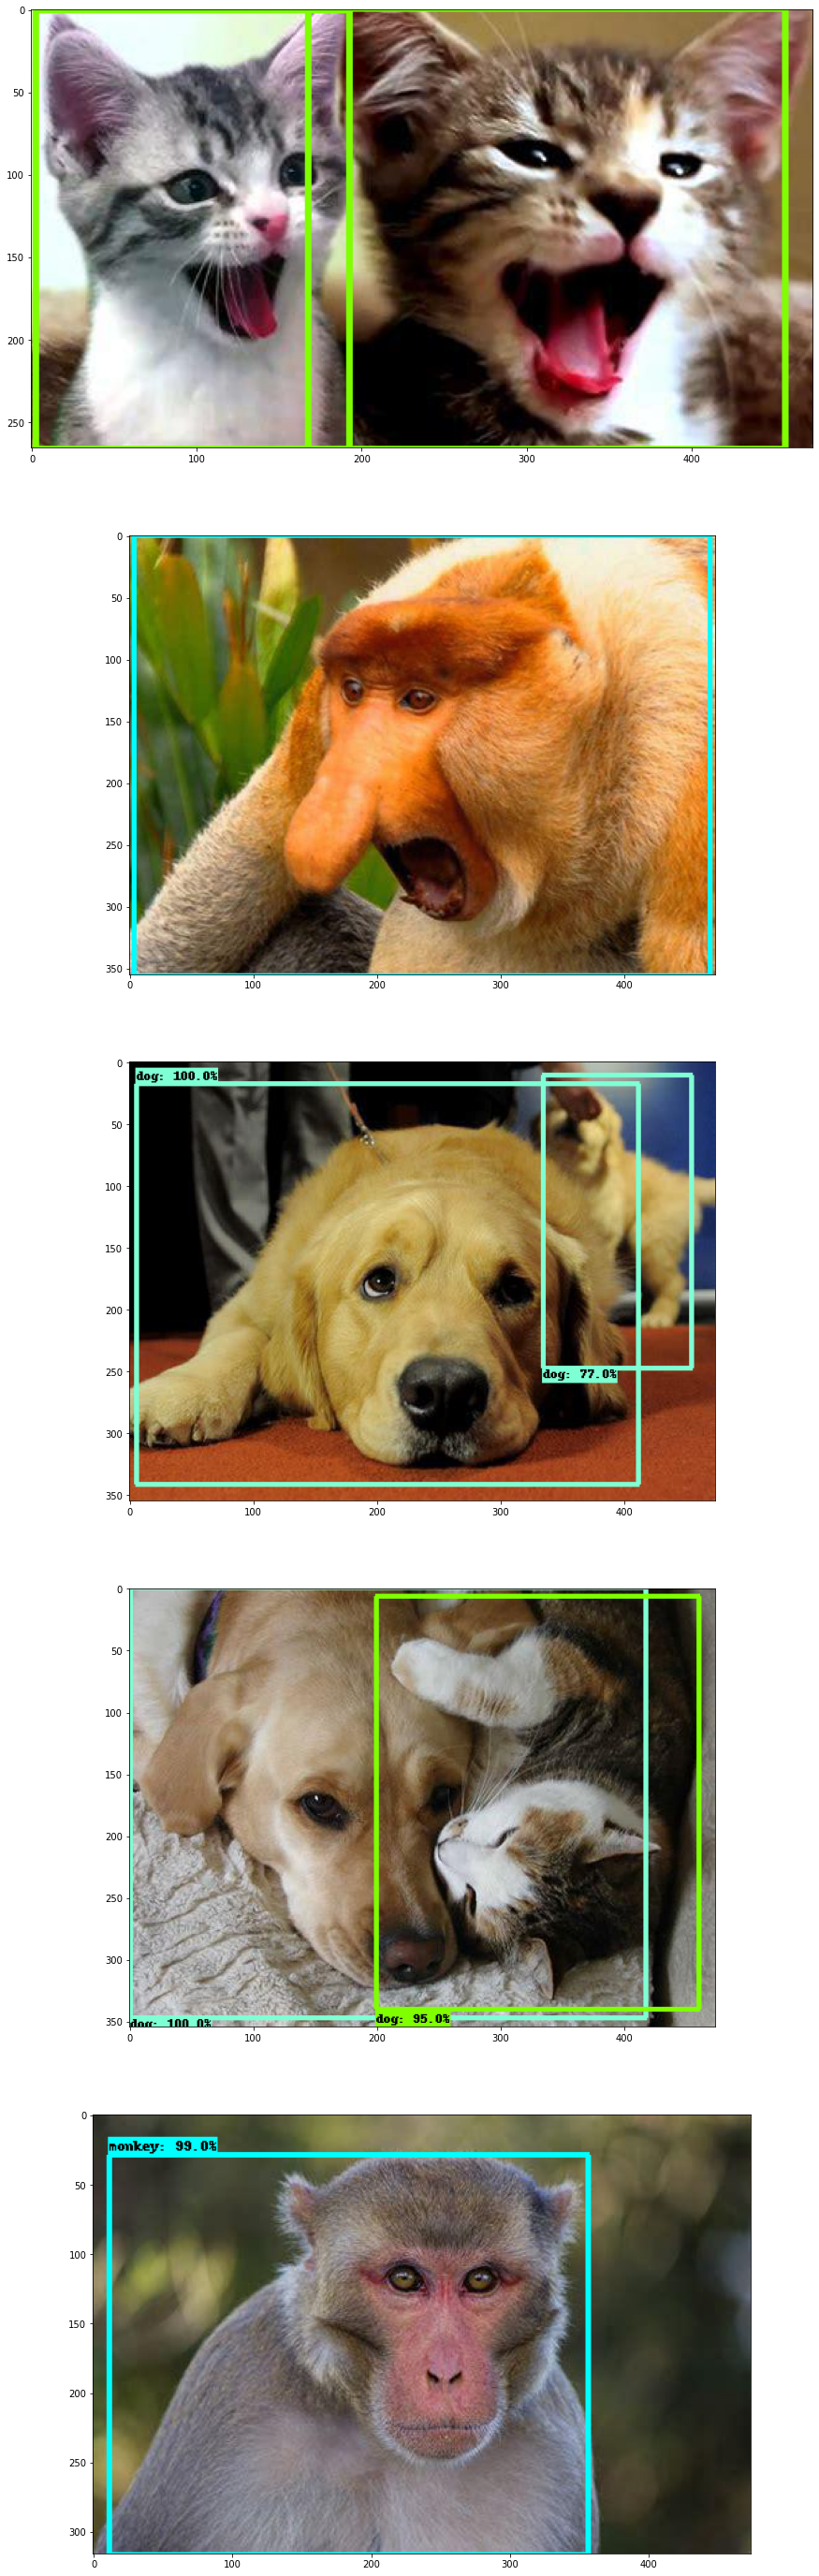

In [44]:
import time

image_dir = '/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/images/my_inference_check'

elapsed = []
for i in range(5):
  image_path = os.path.join(image_dir, 'image' + str(i + 10) + '.jpg')
  image_np = load_image_into_numpy_array(image_path)
  input_tensor = np.expand_dims(image_np, 0)
  start_time = time.time()
  detections = detect_fn(input_tensor)
  end_time = time.time()
  elapsed.append(end_time - start_time)

  plt.rcParams['figure.figsize'] = [100, 50]
  label_id_offset = 1
  image_np_with_detections = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.int32),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.60,
        agnostic_mode=False)
#   if i == 0 :
#         print(detections['detection_boxes'][0].numpy(), detections['detection_boxes'][0].shape)
#         print(detections['detection_scores'][0].numpy())
  plt.subplot(5, 1, i+1)
  plt.imshow(image_np_with_detections)

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

print(detections.keys())


## 다음은 변환한 tflite 모델 추론

In [15]:
#this is for testing tflite model
# Other imports

import matplotlib
import matplotlib.pyplot as plt

import cv2
import time
import numpy as np

from PIL import Image

In [19]:
#@title TFLite Interpreter and detection utils 
#@markdown Sourced from [here](https://github.com/tensorflow/examples/blob/master/lite/examples/object_detection/raspberry_pi/detect_picamera.py).

def set_input_tensor(interpreter, image):
  """Sets the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Returns the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all output details
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
          'bounding_box': boxes[i],
          'class_id': classes[i],
          'score': scores[i]
      }
      results.append(result)
  return results

def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all output details
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
          'bounding_box': boxes[i],
          'class_id': classes[i],
          'score': scores[i]
      }
      results.append(result)
  return results

In [8]:
!pwd

/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset


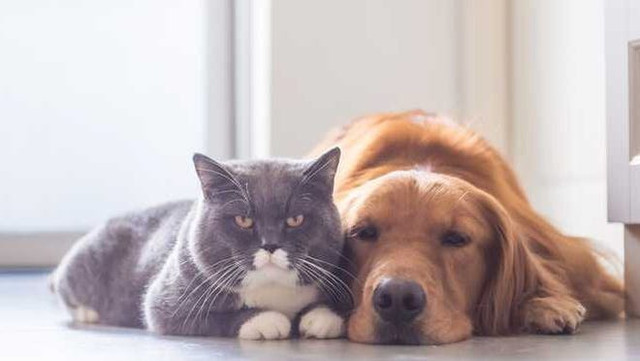

In [20]:
#@title Supply a path to download a relevant image
IMAGE_PATH = "https://i.ibb.co/Bw5bSt1/Motley-Fool-TMOT-816b1ceb-0ece06e3.jpg" #@param {type:"string"}

!wget -q -O image.png $IMAGE_PATH
Image.open('image.png')

In [21]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/home/yousungchoi/projects/yousung_racoon/tf2_object_detection_dataset/workspace/training_demo/exported-models/exported_for_tflite/saved_model/converted_model_from_tfnightly.tflite")
interpreter.allocate_tensors()
_, HEIGHT, WIDTH, _ = interpreter.get_input_details()[0]['shape']
print(f"Height and width accepted by the model: {HEIGHT, WIDTH}")

Height and width accepted by the model: (320, 320)


In [22]:
#@title Image preprocessing utils
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    original_image = img
    resized_img = tf.image.resize(img, (HEIGHT, WIDTH))
    resized_img = resized_img[tf.newaxis, :]
    return resized_img, original_image

In [30]:
#@title Define the label dictionary and color map
LABEL_DICT = {0 : 'whatthe',
    1: 'cat',
    2: 'monkey',
    3: 'dog'
}

COLORS = np.random.randint(0, 255, size=(len(LABEL_DICT), 3), 
                            dtype="uint8")

In [31]:
print(LABEL_DICT[1])

cat


In [32]:
#@title Inference utils
def display_results(image_path, threshold=0.3):
    # Load the input image and preprocess it
    preprocessed_image, original_image = preprocess_image(image_path)
    # print(preprocessed_image.shape, original_image.shape)

    # =============Perform inference=====================
    start_time = time.monotonic()
    results = detect_objects(interpreter, preprocessed_image, threshold=threshold)
    print(f"Elapsed time: {(time.monotonic() - start_time)*1000} miliseconds")

    # =============Display the results====================
    original_numpy = original_image.numpy()
    for obj in results:
        # Convert the bounding box figures from relative coordinates
        # to absolute coordinates based on the original resolution
        ymin, xmin, ymax, xmax = obj['bounding_box']
        xmin = int(xmin * original_numpy.shape[1])
        xmax = int(xmax * original_numpy.shape[1])
        ymin = int(ymin * original_numpy.shape[0])
        ymax = int(ymax * original_numpy.shape[0])

        # Grab the class index for the current iteration
        idx = int(obj['class_id'])
        print(idx)
        # Skip the background
        if idx >= len(LABEL_DICT):
            continue

        # draw the bounding box and label on the image
        color = [int(c) for c in COLORS[idx]]
        cv2.rectangle(original_numpy, (xmin, ymin), (xmax, ymax), 
                    color, 2)
        y = ymin - 15 if ymin - 15 > 15 else ymin + 15
        label = "{}: {:.2f}%".format(LABEL_DICT[obj['class_id']],
            obj['score'] * 100)
        cv2.putText(original_numpy, label, (xmin, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # return the final ima
    original_int = (original_numpy * 255).astype(np.uint8)
    return original_int

Elapsed time: 27.78224996291101 miliseconds
0
2


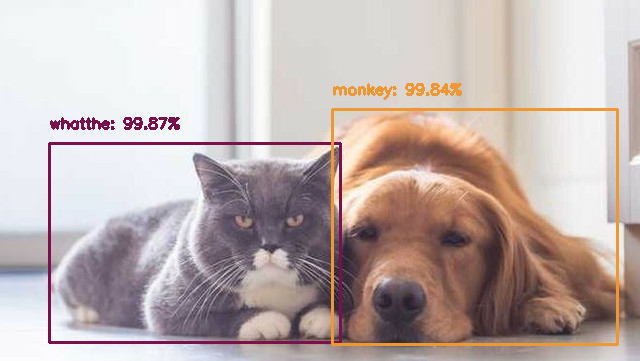

In [33]:
resultant_image = display_results("image.png")
Image.fromarray(resultant_image)